# Tarea de Clustering

## Introducción
Esta tarea consiste en la implementación en python del algoritmo de k-means desde cero, tomando en cuenta las siguientes características:
<ol>
    <li>
        <strong>Comparación de implementaciones de k-means:</strong> Se ha realizado una comparación de los resultados obtenidos con el algoritmo implementado desde cero y el algoritmo que ofrece la librería <a href="https://scikit-learn.org/stable/">sickit-learn</a>.
    </li>
    <li>
        <strong>Comparación de algoritmos:</strong> Se ha realizado una comparación de resultados entre los algoritmos k-medoids y k-means.
    </li>
    <li>
        <strong>Uso de clustering jerárquico:</strong> ...
    </li>
    <li>
        <strong>Evaluación del rendimiento:</strong> Se ha utilizado la silueta para evaluar el rendimiento de todos los métodos.
    </li>    
</ol>

<strong>Estudiante:</strong> Mónica Gabriela Cabañas Meléndez 

### Importación de librerías necesarias y carga de datos

In [159]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [160]:
# Loading the data
data = pd.read_csv('data.csv')
data.drop(columns='color', inplace=True)
# Displaying the first 5 rows of the data
data.head(5)

,x,y
0,516.012706,393.014514
1,436.211762,408.656585
2,512.052601,372.022014
3,489.140464,401.807159
4,446.207986,338.516682


### Visualización de datos

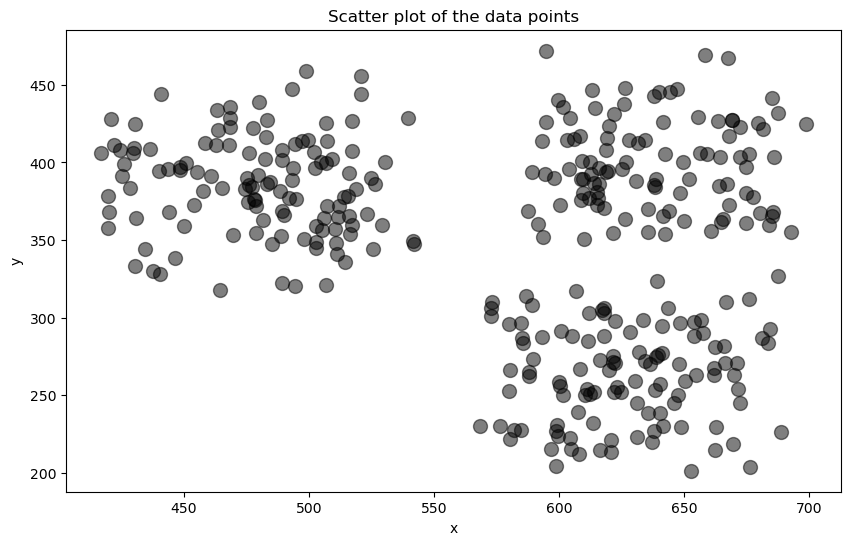

In [161]:
# Function to plot the data points of two features
def plot_data(feature1, feature2):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[feature1], data[feature2], s=100, c='black', alpha=0.5)
    plt.title('Scatter plot of the data points')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

# Ploting the data points of two features
plot_data(data.columns[0], data.columns[1])

### Inicialización de centroides

Uno de los primeros pasos para ejecutar el algoritmo de K-Means es inicializar los centroides que no son más que puntos con $ d $ dimensiones que serán ubicados en el espacio de manera aleatoria. Para ello procederemos a crear una matriz de dimensión $K \times d$ que contendrá los $ K $ centroides en donde cada fila representa un punto en la dimensión $d$.

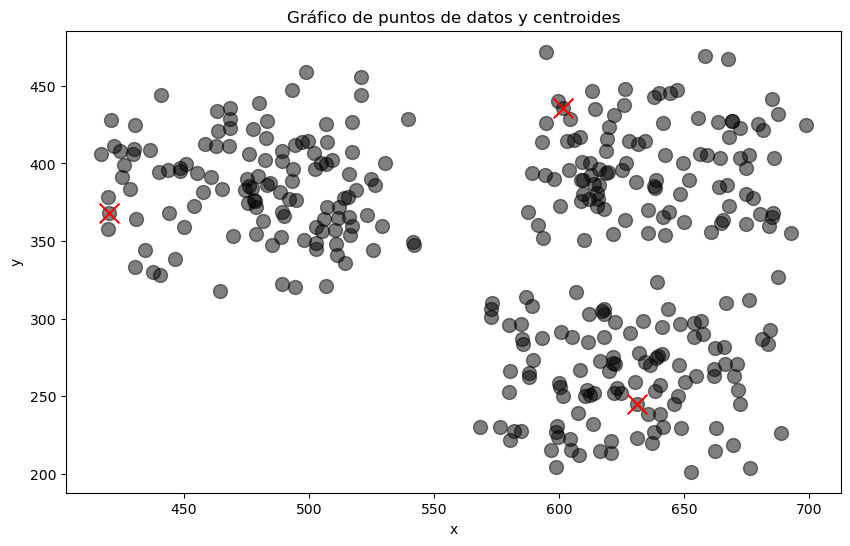

In [162]:
K = 3
centroids_df = data.sample(K)
centroids = np.array(centroids_df)

# Function to plot the data points of two features and the centroids
def plot_data_centroids(feature1, feature2, centroids):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[feature1], data[feature2], s=100, c='black', alpha=0.5)
    plt.scatter(centroids[feature1], centroids[feature2], c='red', s=200, marker='x')
    plt.title('Gráfico de puntos de datos y centroides')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

# Ploting the data points of two features and the centroids
plot_data_centroids(data.columns[0], data.columns[1], centroids_df)

### Distancia euclidiana

Para encontrar la distancia entre dos puntos $(x_{1}^{(1)}, x_{2}^{(1)})$,  $(x_{1}^{(2)}, x_{2}^{(2)})$ en donde solo hay dos dimensiones: $x_{1}$ y $x_{2}$, esta se calcula de la siguiente manera: 

$$ 
    \sqrt{(x_{1}^{(1)} - x_{1}^{(2)})^2 + (x_{2}^{(1)} - x_{2}^{(2)})^2} 
$$

Si se le agregan más dimensiones a ambos puntos por igual la distancia euclídea podrá ser calculada de la siguiente manera:
$$
    \sqrt{\sum_{i = 1}^d{(punto1 - punto2)^2}}
$$

Dado de que en la vida real se utilizan $ d $ dimensiones para entrenar un modelo, el código para calcular la distancia euclídea se ha realizado tomando en cuenta las siguientes características 
* La función recibe dos vectores con dimensiones $1 \times d$
* Cada vector representa un punto con $ d $ dimensiones

In [163]:
# Function for obtaining the result of the euclidean distance between two matrices
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

### Algoritmo de K Means

*
*
*

In [164]:
def kmeans_from_scratch(data, K, centroids, max_iters):
    distances = np.zeros((data.shape[0], K))
    cluster_assignments = np.zeros(data.shape[0], dtype=int)
    new_centroids = np.zeros((K, data.shape[1]))
    cluster_points = []

    for i in range(max_iters):

        # Assigning the data points to the closest centroid
        for i in range(data.shape[0]): 
            for j in range(K): 
                distances[i][j] = euclidean_distance(data.values[i], centroids[j])
            cluster_assignments[i] = np.argmin(distances[i])

        # Creating clusters
        for i in range(K):
            for j in range(data.shape[0]):
                if(cluster_assignments[j] == i):
                    cluster_points.append(data.values[j])
            # Updating the centroids
            new_centroids[i] = np.array(cluster_points).mean(axis=0)
            cluster_points = []

        centroids = new_centroids

        if(np.all(centroids == new_centroids)):
            break

    return centroids

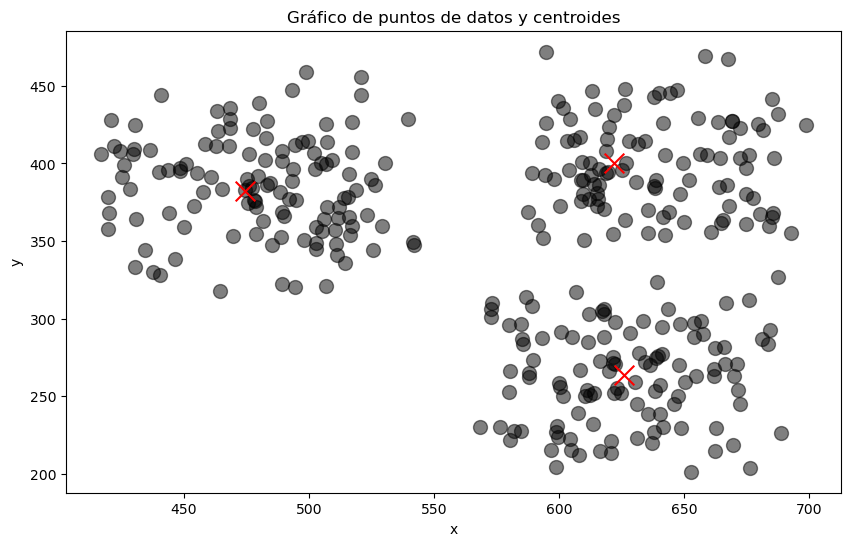

In [165]:

# Applying the K-means algorithm
centroids = kmeans_from_scratch(data, K, centroids, 100)
centroids_df = pd.DataFrame(centroids, columns=data.columns)

# Ploting the data points of two features and the centroids
plot_data_centroids(data.columns[0], data.columns[1], centroids_df)